# Signing GS1 Data Matrix Barcodes

As part of my exploration of inventory and how you might keep some kind of
traceability in parts, I wanted to explore the idea of using signatures on [GS1](https://www.gs1.org/)
formatted [data matrix](https://en.wikipedia.org/wiki/Data_Matrix) barcodes. To
do this, I used a few Python libraries: cyptography, biip, Pillow, and
pylibdmtx. 

WARNING! I haven't really thought through the cryptography here, and you
shouldn't trust me here. This is *just an exploration* of the ideas to see about
their viability, and not a cryptographically secure solution.

## Signing Keys

Before we can go any further, we need to create some keys for us to use. For now, this doesn't really matter that much. For size purposes, though, we are going to stick to elliptic curve crypto to keep the amount of data involved to a minimum.

In [32]:
from cryptography.hazmat.primitives.asymmetric.ed25519 import Ed25519PrivateKey

private_key = Ed25519PrivateKey.generate()
public_key = private_key.public_key()

Now that we have the public/private key pair, we need to work on generating the correct structure for a GS1 code. One of the keys of this system is to use a Function 1 Symbol Character (FNC1), which is used to both indicate the format of the sequence, and to (optionally) separate fields. The ASCII Group Separator (GS) character can also be used to separate variable length fields.

In [33]:
fnc1 = bytes([202])
gs = bytes([29])

Now let's put together the information that we want to smash into the GS1 data:

In [94]:
part_number = b"00312345678906"  # N14
production_date = b"230530"
serial_number = b"445423"
batch_number = b"20230423"

# Application Identifiers
ai_gtin = b"01"
ai_production_date = b"11"
ai_serial_number = b"21"
ai_batch_number = b"10"
ai_custom = b"91"

Putting this together with [the GS1 element string structure](https://www.gs1.org/standards/gs1-datamatrix-guideline/25#2-Encoding-data+2-2-GS1-element-strings), we can use this format string:

In [96]:
gs1_format = ai_gtin + part_number + ai_production_date + production_date + ai_batch_number + batch_number + gs + ai_serial_number + serial_number

print(gs1_format)

b'0100312345678906112305301020230423\x1d21445423'


Now, let's make sure this parses properly.

In [97]:
from biip.gs1 import GS1Message

gs1_message = GS1Message.parse(gs1_format.decode("utf-8"))

print([es.ai.data_title for es in gs1_message.element_strings])
print(f"HRI: {gs1_message.as_hri()}")

['GTIN', 'PROD DATE', 'BATCH/LOT', 'SERIAL']
HRI: (01)00312345678906(11)230530(10)20230423(21)445423


Now to turn this into a Datamatrix using the pylibdmtx library.

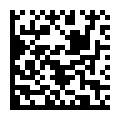

In [98]:
from pylibdmtx.pylibdmtx import encode
from PIL import Image

def convert_to_dm(b: bytes):
    """Convert the provided bytes object to a PIL Image."""
    dm_encoded = encode(b)
    return Image.frombytes("RGB", (dm_encoded.width, dm_encoded.height), dm_encoded.pixels)

display(convert_to_dm(gs1_format))

## Adding a Signature

The next step is to take the information and combine it together with a signature. We are going to do this using the public/private key pair generated earlier. This will sign everything from `gs1_format` except for the first byte (FNC1). We will also verify that it's properly round-tripping.

In [99]:
message = gs1_format[1:]

signature = private_key.sign(message)

# Now verify it
try:
    public_key.verify(signature, message)
    print("Message verified")
except:
    print("VERIFICATION FAILED")


Message verified


Now we can insert this into the Datamatrix. First, we need to convert it into safe ASCII characters. We will do this using base64 encoding. Unfortunately, we can't use ASCII85, as it contains invalid characters. Fortunately, it is only 88 characters (out of 90 available). Whew!

In [100]:
import base64

encoded_signature = base64.b64encode(signature)
print(f"Length of signature: {len(encoded_signature)}")
signed_gs1_format = gs1_format + gs + ai_custom + encoded_signature

Length of signature: 88


Finally, we can turn THAT back into a Datamatrix.

Length of the original GS1 data: 43
Length of the signed GS1 data: 134
['GTIN', 'PROD DATE', 'BATCH/LOT', 'SERIAL', 'INTERNAL']
HRI: (01)00312345678906(11)230530(10)20230423(21)445423(91)syZ/bdMksNbJjn1IOnJYeUEzYT2kLlpxuoghi796MT8Q9BYZt9HvuLV6W4OpFXTMyUbSFdNoN0W//ZWAj42KBQ==


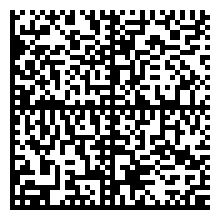

In [101]:
print(f"Length of the original GS1 data: {len(gs1_format)}")
print(f"Length of the signed GS1 data: {len(signed_gs1_format)}")

gs1_signed_message = GS1Message.parse(signed_gs1_format.decode("utf-8"))

print([es.ai.data_title for es in gs1_signed_message.element_strings])
print(f"HRI: {gs1_signed_message.as_hri()}")

display(convert_to_dm(signed_gs1_format))